**Level 3**
**Task 7: Sales Forecasting Description**

Description:


*   Dataset (Recommended): Walmart Sales Forecast (Kaggle).
*   Predict future sales based on historical sales data.
*   Create time-based features (day, month, lag values).
*   Apply regression models to forecast next period's sales.
*   Plot actual vs. predicted values over time.







Tools & Libraries:


*   Python
*   Pandas
*   Matplotlib
*   Scikit-Learn


Covered Topics:


*   Time series forecasting
*   Regression






Bonus:


*   Use rolling averages and seasonal decomposition.
*   Apply XGBoost or LightGBM with time-aware validation.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor  # fallback if xgb/lgbm not available

In [2]:
df = pd.read_csv("train.csv", parse_dates=["Date"])

Data Visualization

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [4]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df.describe()

,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


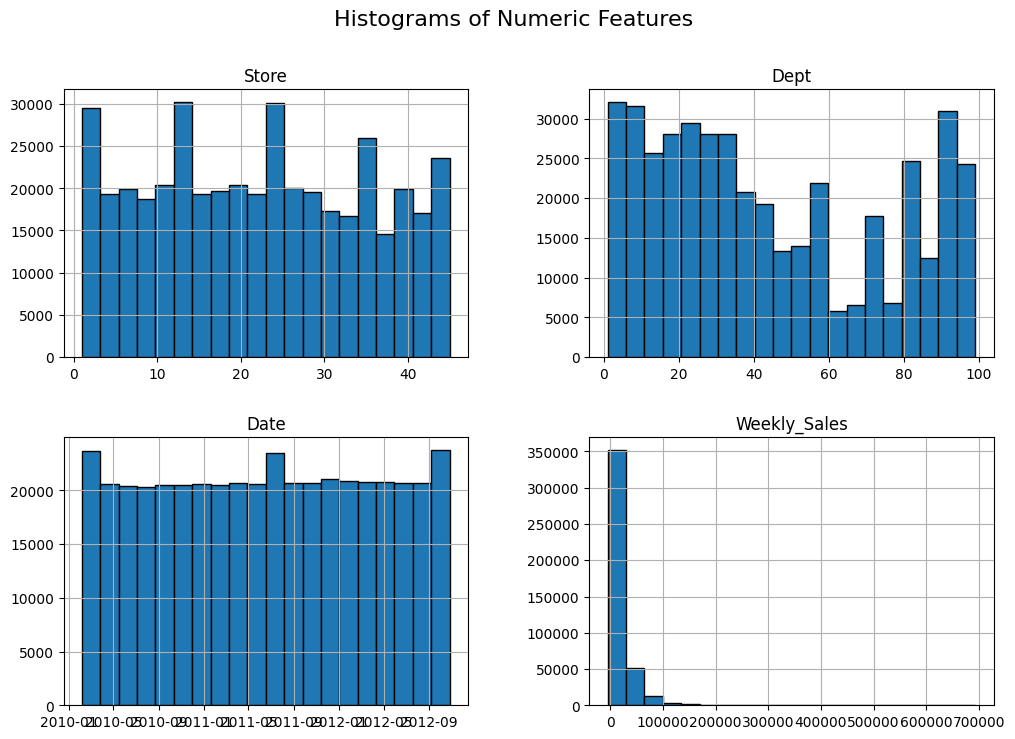

In [6]:
df.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()

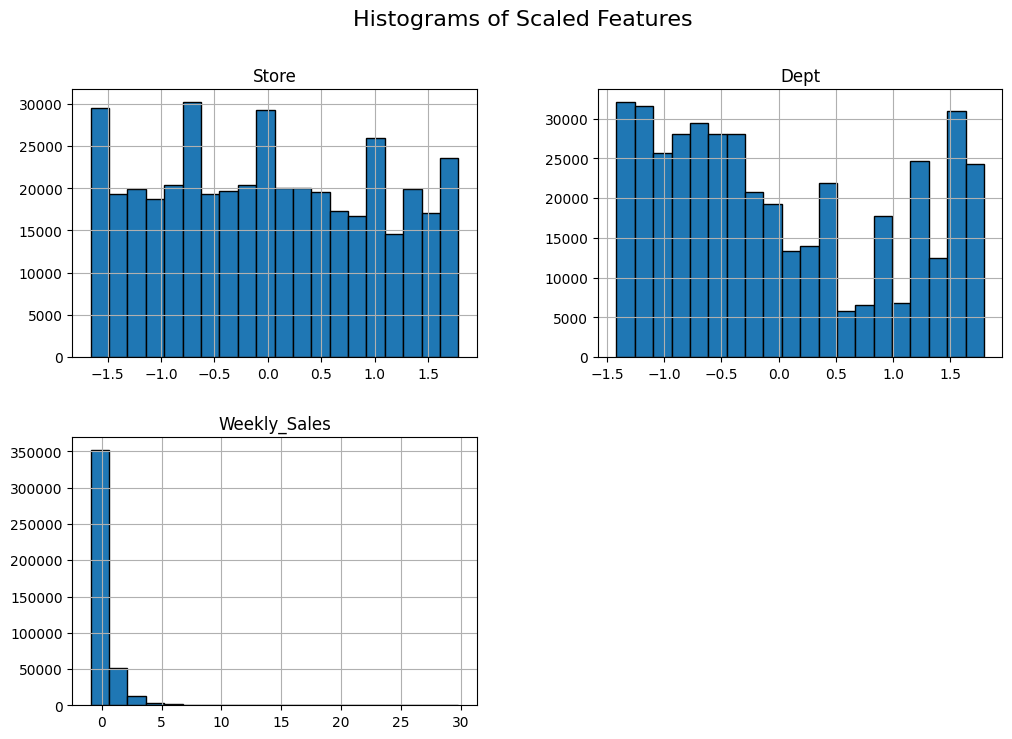

In [7]:
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
scaled_data = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

scaled_data.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histograms of Scaled Features", fontsize=16)
plt.show()

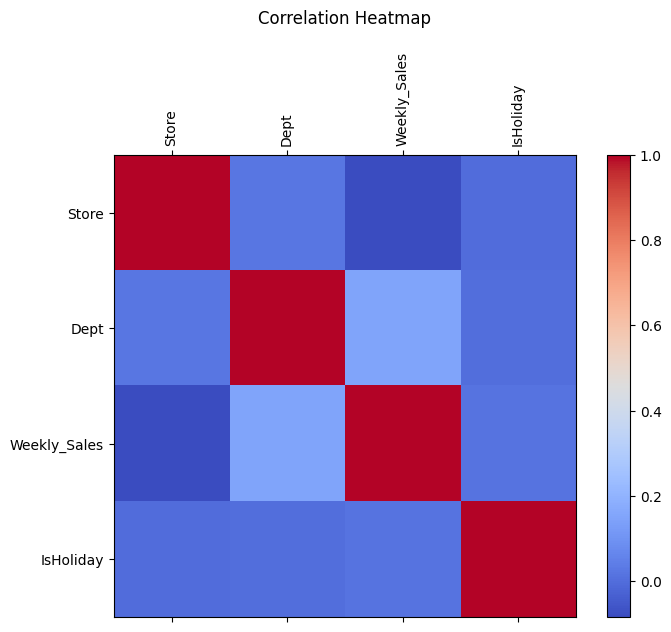

In [9]:
corr = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap="coolwarm")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
fig.colorbar(cax)
plt.title("Correlation Heatmap", pad=20)
plt.show()

In [12]:
print(df.corr()["Weekly_Sales"].sort_values(ascending=False))

Weekly_Sales    1.000000
Dept            0.148032
IsHoliday       0.012774
Date           -0.000663
Store          -0.085195
Name: Weekly_Sales, dtype: float64


Data Cleaning

In [14]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
421565,False
421566,False
421567,False
421568,False


In [16]:
# Handling Missing Values
round((df.isnull().sum()/df.shape[0])*100,2)

,0
Store,0.0
Dept,0.0
Date,0.0
Weekly_Sales,0.0
IsHoliday,0.0


In [18]:
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  # Keep only rows within bounds
  data2 = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  print(data2.shape)

(421570, 5)
(421570, 5)
(386049, 5)


In [21]:
# Converting Categorical Variables
# Categorical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical columns :',cat_col)
# Numerical columns
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : []
Numerical columns : ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']


In [ ]:
# Extract date parts
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["week"] = df["Date"].dt.isocalendar().week.astype(int)
df["day"] = df["Date"].dt.day
df["weekday"] = df["Date"].dt.weekday  # Monday=0, Sunday=6

# Start/end flags
df["is_month_start"] = df["Date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["Date"].dt.is_month_end.astype(int)


In [ ]:
# Sort by Store, Dept, Date
df = df.sort_values(["Store", "Dept", "Date"])

# Lag features (last 1, 2, and 4 weeks)
df["lag_1"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
df["lag_2"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)
df["lag_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)

# Rolling mean (4-week average)
df["rolling_mean_4"] = (
    df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(window=4).mean()
)


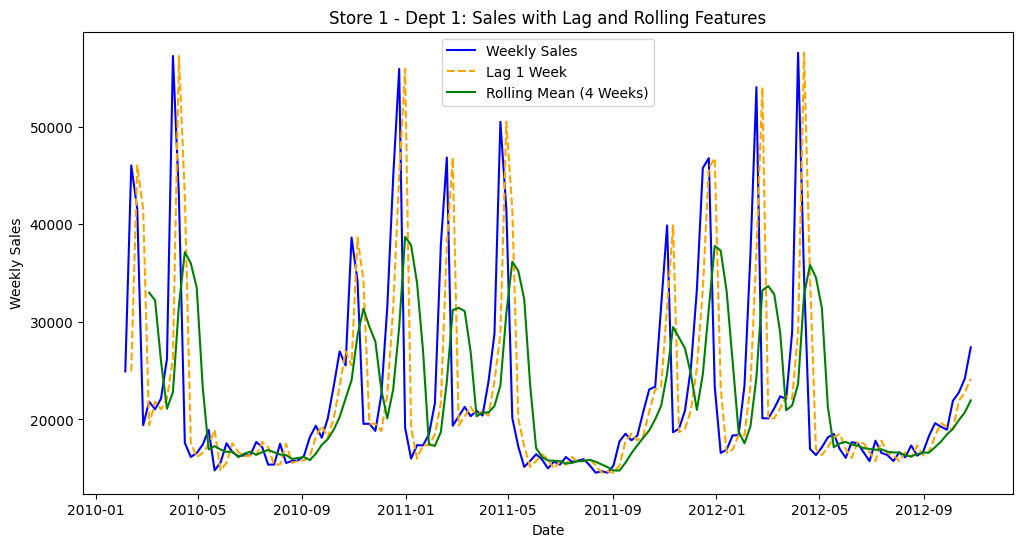

In [ ]:
# Example: Store 1, Dept 1
sample = df[(df["Store"] == 1) & (df["Dept"] == 1)]

plt.figure(figsize=(12,6))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Weekly Sales", color="blue")
plt.plot(sample["Date"], sample["lag_1"], label="Lag 1 Week", linestyle="--", color="orange")
plt.plot(sample["Date"], sample["rolling_mean_4"], label="Rolling Mean (4 Weeks)", color="green")
plt.title("Store 1 - Dept 1: Sales with Lag and Rolling Features")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


In [ ]:
# Drop rows with NaN (from lag/rolling)
df_model = df.dropna()

# Features and target
features = [
    "year","month","week","day","weekday",
    "is_month_start","is_month_end",
    "lag_1","lag_2","lag_4","rolling_mean_4"
]
X = df_model[features]
Y = df_model["Weekly_Sales"]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Random Forest baseline
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 1671.1528846463023


In [ ]:
# Features & target
features = ["lag_1","lag_2","lag_4","rolling_mean_4","year","month","week","weekday"]
X = df[features]
Y = df["Weekly_Sales"]

# Time-based split (last 20% as test)
split = int(len(df) * 0.8)
x_train, x_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = Y.iloc[:split], Y.iloc[split:]


In [ ]:
models = {
    "Linear Regression": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
    ])
}


In [ ]:
# Handles NaNs via SimpleImputer inside each model pipeline

# --- If the target might contain NaNs, drop those rows safely ---
def drop_target_nans(X, y):
    mask = y.notna()
    return X.loc[mask], y.loc[mask]

x_train_clean, y_train_clean = drop_target_nans(x_train, y_train)
x_test_clean,  y_test_clean  = drop_target_nans(x_test,  y_test)

# --- Build pipelines: impute features, then fit the model ---
def make_pipeline(estimator):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # you can switch to "mean"
        ("model", estimator)
    ])

models = {
    "Linear Regression": make_pipeline(LinearRegression()),
    "Random Forest":     make_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    "Gradient Boosting": make_pipeline(GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)),
}

results = {}

for name, pipe in models.items():
    pipe.fit(x_train_clean, y_train_clean)
    y_pred = pipe.predict(x_test_clean)

    mae = mean_absolute_error(y_test_clean, y_pred)
    rmse = mean_squared_error(y_test_clean, y_pred) ** 0.5  # no NumPy; use **0.5

    results[name] = {"MAE": mae, "RMSE": rmse}
    print(f"\n{name}")
    print(f"MAE :  {mae:.2f}")
    print(f"RMSE:  {rmse:.2f}")

# Nice summary
summary = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\nSummary (lower is better):\n", summary)



Linear Regression
MAE :  1944.20
RMSE:  5148.75

Random Forest
MAE :  1751.16
RMSE:  4607.08

Gradient Boosting
MAE :  1729.90
RMSE:  4464.66

Summary (lower is better):
                            MAE         RMSE
Gradient Boosting  1729.899213  4464.659458
Random Forest      1751.161366  4607.080653
Linear Regression  1944.201915  5148.753499


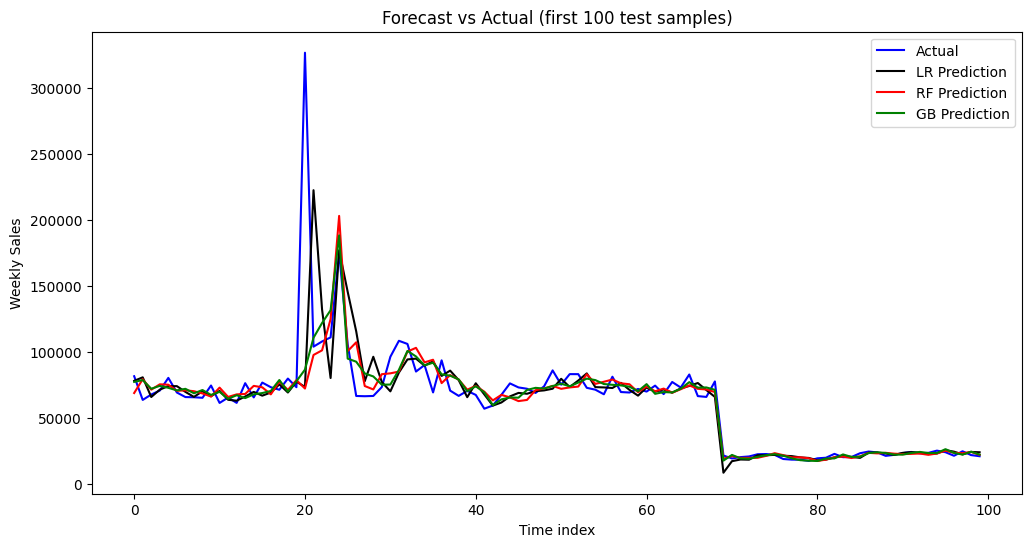

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", color="blue")
plt.plot(models["Linear Regression"].predict(x_test)[:100], label="LR Prediction", color="black")
plt.plot(models["Random Forest"].predict(x_test)[:100], label="RF Prediction", color="red")
plt.plot(models["Gradient Boosting"].predict(x_test)[:100], label="GB Prediction", color="green")
plt.title("Forecast vs Actual (first 100 test samples)")
plt.xlabel("Time index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


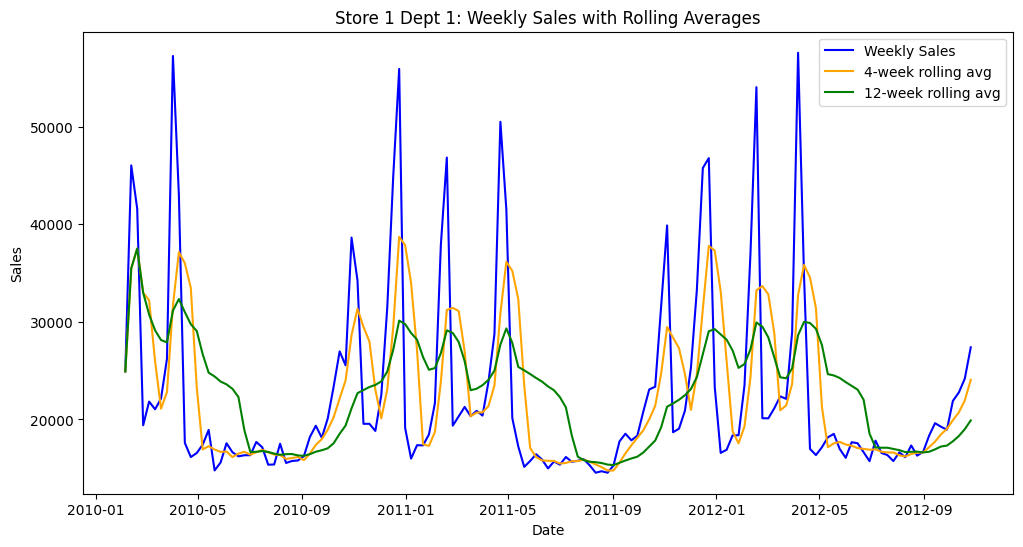

In [ ]:
# Load data
df = pd.read_csv("train.csv", parse_dates=["Date"])
df = df.sort_values(["Store", "Dept", "Date"])

# Create rolling averages for Weekly_Sales per Store+Dept
df["roll_mean_4"]  = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
df["roll_mean_12"] = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Quick visualization (Store 1, Dept 1)
sample = df[(df["Store"]==1) & (df["Dept"]==1)]
plt.figure(figsize=(12,6))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Weekly Sales", color="blue")
plt.plot(sample["Date"], sample["roll_mean_4"], label="4-week rolling avg", color="orange")
plt.plot(sample["Date"], sample["roll_mean_12"], label="12-week rolling avg", color="green")
plt.title("Store 1 Dept 1: Weekly Sales with Rolling Averages")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend()
plt.show()


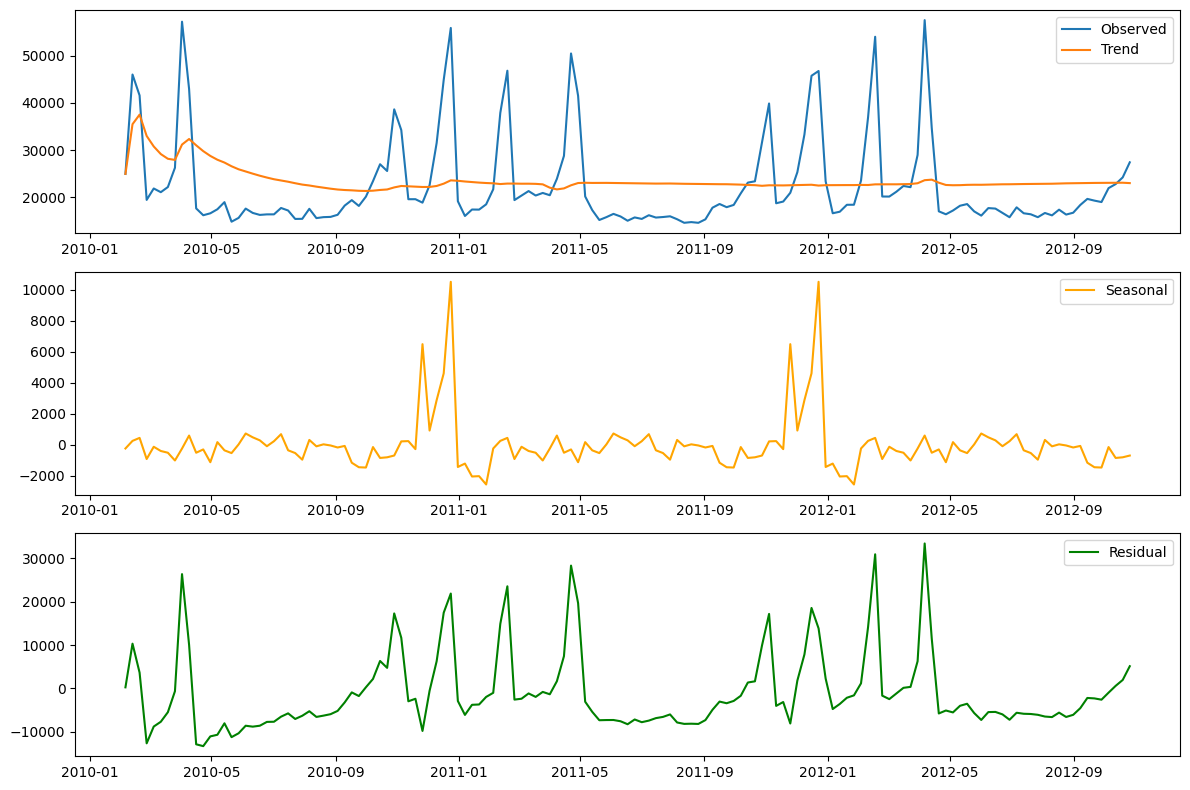

In [ ]:
# Trend: long rolling average
df["trend"] = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=52, min_periods=1).mean())

# Remove trend
df["detrended"] = df["Weekly_Sales"] - df["trend"]

# Estimate seasonality: average detrended sales per week of year
df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
seasonality = df.groupby("weekofyear")["detrended"].mean()

# Map back to each row
df["seasonal"] = df["weekofyear"].map(seasonality)

# Residual
df["resid"] = df["Weekly_Sales"] - df["trend"] - df["seasonal"]

# Example visualization (Store 1 Dept 1)
sample = df[(df["Store"]==1) & (df["Dept"]==1)]
plt.figure(figsize=(12,8))
plt.subplot(3,1,1); plt.plot(sample["Date"], sample["Weekly_Sales"], label="Observed"); plt.plot(sample["Date"], sample["trend"], label="Trend"); plt.legend()
plt.subplot(3,1,2); plt.plot(sample["Date"], sample["seasonal"], label="Seasonal", color="orange"); plt.legend()
plt.subplot(3,1,3); plt.plot(sample["Date"], sample["resid"], label="Residual", color="green"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
# Drop NaNs from rolling/decomposition
df_model = df.dropna()

features = [
    "roll_mean_4","roll_mean_12","trend","seasonal","weekofyear"
]
X = df_model[features]
Y = df_model["Weekly_Sales"]

# Time-based split (last 20% for testing)
#split = int(len(df_model) * 0.8)
#X_train, X_test = X.iloc[:split], X.iloc[split:]
#y_train, y_test = y.iloc[:split], y.iloc[split:]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # no numpy
    results[name] = {"MAE": mae, "RMSE": rmse}

    print(f"\n{name}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")


#model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#model.fit(x_train, y_train)
#y_pred = model.predict(x_test)

#mae = mean_absolute_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred) ** 0.5
#print("MAE:", mae, " RMSE:", rmse)



Linear Regression
MAE : 1351.91
RMSE: 4135.77

Random Forest
MAE : 954.54
RMSE: 2640.85

Gradient Boosting
MAE : 1076.78
RMSE: 3006.38


In [ ]:
summary = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\nSummary (lower is better):\n", summary)



Summary (lower is better):
                            MAE         RMSE
Random Forest       954.537309  2640.845938
Gradient Boosting  1076.779653  3006.379233
Linear Regression  1351.910274  4135.766299


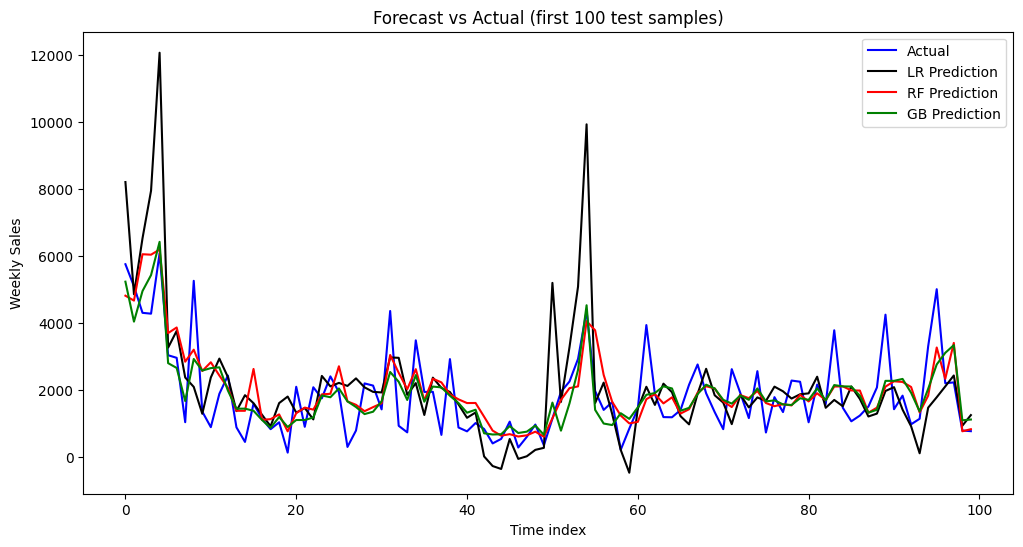

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", color="blue")
plt.plot(models["Linear Regression"].predict(x_test)[:100], label="LR Prediction", color="black")
plt.plot(models["Random Forest"].predict(x_test)[:100], label="RF Prediction", color="red")
plt.plot(models["Gradient Boosting"].predict(x_test)[:100], label="GB Prediction", color="green")
plt.title("Forecast vs Actual (first 100 test samples)")
plt.xlabel("Time index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


In [ ]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

lr.fit(x_train, y_train)
rf.fit(x_train, y_train)
gb.fit(x_train, y_train)

# ========== 3) Feature Importances ==========
importances = {}

# Linear Regression coefficients
lr_importance = pd.Series(lr.coef_, index=features).abs()
importances["Linear Regression"] = lr_importance / lr_importance.sum()

# Random Forest feature importances
rf_importance = pd.Series(rf.feature_importances_, index=features)
importances["Random Forest"] = rf_importance / rf_importance.sum()

# Gradient Boosting feature importances
gb_importance = pd.Series(gb.feature_importances_, index=features)
importances["Gradient Boosting"] = gb_importance / gb_importance.sum()

# Combine into one DataFrame
importance_df = pd.DataFrame(importances).round(3)

print("\n=== Feature Importance Comparison ===")
print(importance_df)

# ========== 4) Plot ==========
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, (name, imp) in zip(axes, importances.items()):
    imp.sort_values().plot(kind="barh", ax=ax, color="skyblue")
    ax.set_title(f"{name} Feature Importance")
    ax.set_xlabel("Relative Importance")

plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 70265, number of used features: 5
[LightGBM] [Info] Start training from score 16006.113063


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 140526, number of used features: 5
[LightGBM] [Info] Start training from score 16278.026764


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 210787, number of used features: 5
[LightGBM] [Info] Start training from score 15956.927759


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 281048, number of used features: 5
[LightGBM] [Info] Start training from score 15958.372306


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 351309, number of used features: 5
[LightGBM] [Info] Start training from score 16011.606200


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Time-aware CV (expanding window) — lower is better ===
              Model          MAE         RMSE
0          LightGBM  1496.677679  4216.649124
1  HistGB (sklearn)  1513.916117  4254.975978
2           XGBoost  1536.232147  4319.373351


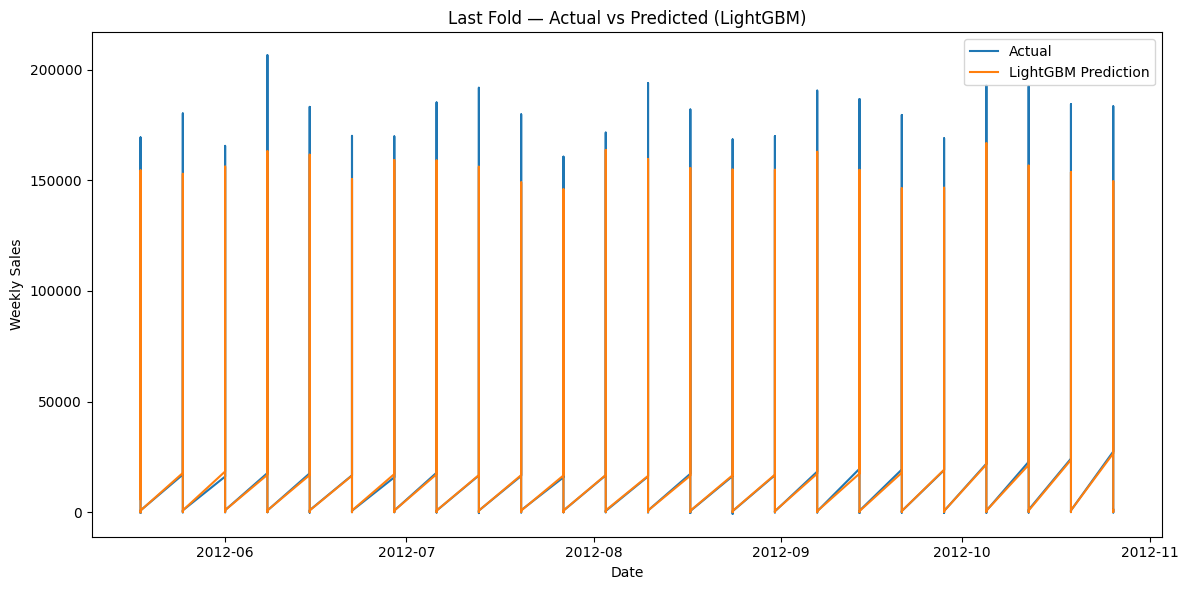

In [ ]:
# =========================
# Time-aware validation with XGBoost / LightGBM (fallback to sklearn)
# =========================

# ---- Try to import XGBoost / LightGBM (optional) ----
xgb_available = False
lgbm_available = False
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    pass

try:
    from lightgbm import LGBMRegressor
    lgbm_available = True
except Exception:
    pass

# 1) Load & feature engineering (rolling + seasonal)
df = pd.read_csv("train.csv", parse_dates=["Date"])
df = df.sort_values(["Store", "Dept", "Date"])

# Rolling averages
df["roll_mean_4"]  = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda s: s.rolling(4, min_periods=1).mean())
df["roll_mean_12"] = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda s: s.rolling(12, min_periods=1).mean())

# Trend (52-week rolling mean)
df["trend"] = df.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda s: s.rolling(52, min_periods=1).mean())

# Detrend & seasonality (by week-of-year)
df["detrended"] = df["Weekly_Sales"] - df["trend"]
df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
seasonality_map = df.groupby("weekofyear")["detrended"].mean()
df["seasonal"] = df["weekofyear"].map(seasonality_map)

# Drop rows with NaNs introduced by rolling at the start
df_model = df.dropna().copy()

# Features / Target
FEATS = ["roll_mean_4", "roll_mean_12", "trend", "seasonal", "weekofyear"]
X = df_model[FEATS]
Y = df_model["Weekly_Sales"]

# Ensure strictly time-ordered by Date for TimeSeriesSplit
order_index = df_model["Date"].argsort(kind="mergesort")  # stable sort to preserve series ordering
X = X.iloc[order_index].reset_index(drop=True)
Y = Y.iloc[order_index].reset_index(drop=True)
dates = df_model["Date"].iloc[order_index].reset_index(drop=True)

# 2) Build candidate models (pick what’s available)
models = {}

if xgb_available:
    models["XGBoost"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            tree_method="hist",
            n_jobs=-1
        ))
    ])

if lgbm_available:
    models["LightGBM"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ])

# Always include a robust sklearn fallback (handles NaNs natively)
models["HistGB (sklearn)"] = HistGradientBoostingRegressor(
    max_depth=None, learning_rate=0.08, max_iter=800, random_state=42
)

# Wrap fallback in a pipeline for uniform API (add imputer no-op via passthrough)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
models["HistGB (sklearn)"] = make_pipeline(
    FunctionTransformer(lambda df: df, feature_names_out="one-to-one"),  # passthrough
    models["HistGB (sklearn)"]
)

# 3) Time-aware backtesting (expanding window)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

summary_rows = []
last_fold_preds = {}  # for plotting

for model_name, pipe in models.items():
    fold_mae = []
    fold_rmse = []
    fold_id = 0
    y_plot_true, y_plot_pred, dates_plot = None, None, None

    for train_idx, test_idx in tscv.split(X):
        fold_id += 1
        x_tr, x_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = Y.iloc[train_idx], Y.iloc[test_idx]
        d_te = dates.iloc[test_idx]

        # If using XGB/LGBM, pass eval_set for early stopping
        if model_name in ("XGBoost", "LightGBM"):
            model = pipe.named_steps["model"]
            # Fit the full pipeline except final model to get imputed features
            x_tr_imp = pipe.named_steps["imputer"].fit_transform(x_tr)
            x_te_imp = pipe.named_steps["imputer"].transform(x_te)

            if model_name == "XGBoost":
                model.set_params(early_stopping_rounds=50)
                model.fit(x_tr_imp, y_tr, eval_set=[(x_te_imp, y_te)], verbose=False)
                y_hat = model.predict(x_te_imp)
            else:
                from lightgbm import early_stopping
                model.set_params(n_estimators=1000)
                model.fit(
                  x_tr_imp, y_tr,
                  eval_set=[(x_te_imp, y_te)],
                  eval_metric="l1",
                  callbacks=[early_stopping(50, verbose=False)]
                )
                y_hat = model.predict(x_te_imp)
        else:
            # Pure sklearn pipeline (HistGB)
            pipe.fit(x_tr, y_tr)
            y_hat = pipe.predict(x_te)

        mae = mean_absolute_error(y_te, y_hat)
        rmse = mean_squared_error(y_te, y_hat) ** 0.5  # no numpy
        fold_mae.append(mae)
        fold_rmse.append(rmse)

        # Keep last fold for plotting
        y_plot_true, y_plot_pred, dates_plot = y_te, pd.Series(y_hat, index=y_te.index), d_te

    # Aggregate scores
    avg_mae = sum(fold_mae) / len(fold_mae)
    avg_rmse = sum(fold_rmse) / len(fold_rmse)
    summary_rows.append({"Model": model_name, "MAE": avg_mae, "RMSE": avg_rmse})

    last_fold_preds[model_name] = (dates_plot, y_plot_true, y_plot_pred)

# 4) Results table
summary_df = pd.DataFrame(summary_rows).sort_values(by="RMSE").reset_index(drop=True)
print("\n=== Time-aware CV (expanding window) — lower is better ===")
print(summary_df)

# 5) Quick plot: last fold predictions vs actual for the best model
best_model = summary_df.iloc[0]["Model"]
dates_plot, y_true_plot, y_pred_plot = last_fold_preds[best_model]

plt.figure(figsize=(12,6))
plt.plot(dates_plot.values, y_true_plot.values, label="Actual", linewidth=1.5)
plt.plot(dates_plot.values, y_pred_plot.values, label=f"{best_model} Prediction", linewidth=1.5)
plt.title(f"Last Fold — Actual vs Predicted ({best_model})")
plt.xlabel("Date"); plt.ylabel("Weekly Sales"); plt.legend()
plt.tight_layout(); plt.show()
